# Load Packages

In [1]:
YAYAY

NameError: name 'YAYAY' is not defined

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Install extra packages needed for this notebook
!pip install -q pyunpack patool rarfile rioxarray

# --- Imports ---

import os
import sys
import pathlib
import requests

import numpy as np
import pandas as pd

import PIL
from PIL import Image

import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.models import *
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import *
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import pyunpack
from rarfile import RarFile
import rioxarray as rxr

from sklearn.metrics import *

from tensorflow.keras.models import Model
from tensorflow.keras.layers import (
    Input, Conv2D, Conv2DTranspose, MaxPooling2D,
    Dropout, BatchNormalization, Activation, UpSampling2D,
    concatenate, add, multiply,
)
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import binary_crossentropy
from tensorflow.keras import backend as K



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.9/87.9 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 6.9 MB/s eta 0:00:00


In [ ]:
download = True # True, if files don't already exist in same directory


In [ ]:
# Download data

# Download data
if download:
    url = 'https://zenodo.org/record/3233081/files/Amazon%20Forest%20Dataset.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':  # Windows / Linux
        pyunpack.Archive('data.rar').extractall('')
    else:  # MacOS
        with RarFile('data.rar') as rf:
            rf.extractall()

# Path to dataset
base_dir = r"./Amazon Forest Dataset/"


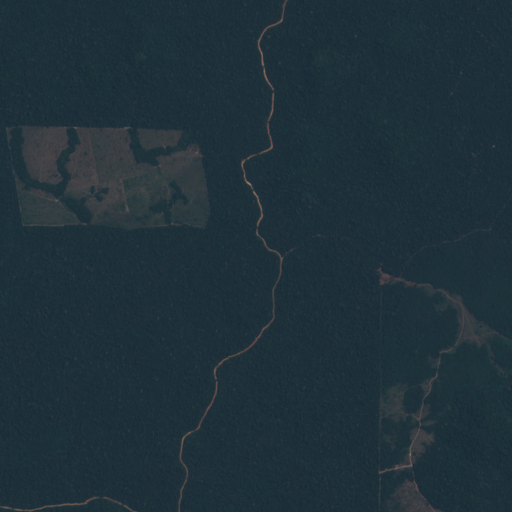

In [ ]:
# Show example image from training data
PIL.Image.open(r"{}Training/images/Amazon_1110.tiff_25.tiff".format(base_dir))

# Functions

In [ ]:
'''
  Returns an image plot of mask prediction
'''

def reconstruct_image(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])
  # Standardise between 0-1
  reconstruction = reconstruction/np.max(reconstruction)

  # Round to 0-1, binary pixel-by-pixel classification
  if rounded:
    reconstruction = np.round(reconstruction)

  # Plot reconstructed mask (prediction)
  plt.imshow(reconstruction)

In [ ]:
'''
  Returns array of mask prediction, given model and image
'''
def reconstruct_array(model, image, rounded=False):

  # Find model prediction
  reconstruction = model.predict(image).reshape(image.shape[1], image.shape[2])

  if rounded:
    reconstruction = np.round(reconstruction)

  return reconstruction # Returns array

In [ ]:
'''
  Metric functions for evaluation
'''

def score_eval(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 3))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def score_eval2(model, image, mask): # Gives score of mask vs prediction
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return accuracy_score(mask.flatten(), reconstruction)

  else: # If a list of images input, find accuracy for each
    scores = []
    for i in range(len(image)):
      reconstruction = model.predict(image[i].reshape(1, 512, 512, 4))
      reconstruction = np.round(reconstruction).flatten()

      scores.append(accuracy_score(mask[i].flatten(), reconstruction))

    return scores

def recall_eval(model, image, mask): # Find recall score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return recall_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    recall = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        recall.append(recall_score(mask[i].flatten(), reconstruction, average='weighted'))

    return recall

def precision_eval(model, image, mask): # Find precision score
  if type(image) != list:
    reconstruction = model.predict(image).reshape(mask.shape[1], mask.shape[2])
    reconstruction = np.round(reconstruction).flatten()

    return precision_score(mask.flatten(), reconstruction, average='weighted')

  else: # If a list of images input, find accuracy for each
    precision = []
    for i in range(len(image)):
        reconstruction = model.predict(image[i]).reshape(mask[i].shape[1], mask[i].shape[2])
        reconstruction = np.round(reconstruction).flatten()

        precision.append(precision_score(mask[i].flatten(), reconstruction, average='weighted'))

    return precision

def f1_score_eval(model, image, mask): # Find F1-score
    prec = np.mean(precision_eval(model, image, mask))
    rec = np.mean(recall_eval(model, image, mask))

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def f1_score_eval_basic(precision, recall):
    prec = np.mean(precision)
    rec = np.mean(recall)

    if prec + rec == 0:
        return 0

    return 2 * (prec * rec) / (prec + rec)

def produce_mask(image): # Outputs rounded image (binary)
  return np.round(image)

# Ingest and Process RGB Dataset

In [ ]:
# Ingest images

## Training images
training_images_list = os.listdir(r"{}Training/images/".format(base_dir))
training_masks_list = []
training_images = []
for n in training_images_list:
  im = PIL.Image.open(r"{}Training/images/{}".format(base_dir,n))
  training_images.append(im)
  training_masks_list.append(n[:-5]+'.png')

## Training masks
training_masks = []
for n in training_masks_list:
  im = PIL.Image.open(r"{}Training/masks/{}".format(base_dir,n))
  training_masks.append(im)

## Test images
test_images_list = os.listdir(r"{}Test/".format(base_dir))
test_images = []
for n in test_images_list:
  im = PIL.Image.open(r"{}Test/{}".format(base_dir,n))
  test_images.append(im)

## Validation images
validation_images_list = os.listdir(r"{}Validation/images/".format(base_dir))
validation_masks_list = []
validation_images = []
for n in validation_images_list:
  im = PIL.Image.open(r"{}Validation/images/{}".format(base_dir,n))
  validation_images.append(im)
  validation_masks_list.append(n[:-5]+'.png')

## Validation masks
validation_masks = []
for n in validation_masks_list:
  im = PIL.Image.open(r"{}Validation/masks/{}".format(base_dir,n))
  validation_masks.append(im)

In [ ]:
# Pre-process data, normalise and reshape
for i in range(len(training_images)):
  training_images[i] = np.array(training_images[i])/255
  training_images[i] = training_images[i].reshape(512,512,3)
  training_images[i] = training_images[i].astype('float32')

for i in range(len(training_masks)):
  training_masks[i] = (np.array(training_masks[i])-1)
  training_masks[i] = training_masks[i][:512,:512]
  training_masks[i] = training_masks[i].reshape(512,512,1)
  training_masks[i] = training_masks[i].astype('int')

for i in range(len(validation_images)):
  validation_images[i] = np.array(validation_images[i])/255
  validation_images[i] = validation_images[i].reshape(1,512,512,3)
  validation_images[i] = validation_images[i].astype('float32')

for i in range(len(validation_masks)):
  validation_masks[i] = np.array(validation_masks[i])-1
  validation_masks[i] = validation_masks[i][:512,:512]
  validation_masks[i] = validation_masks[i].reshape(1,512,512,1)
  validation_masks[i] = validation_masks[i].astype('int')

for i in range(len(test_images)):
  test_images[i] = np.array(test_images[i])/255
  test_images[i] = test_images[i].reshape(1,512,512,3)
  test_images[i] = test_images[i].astype('float32')

# Add some training images to validation data to increase size of validation set
for i in range(25,30):
  validation_images.append(training_images[i].reshape(1,512,512,3))
  validation_masks.append(training_masks[i].reshape(1,512,512,1))

# Remove five images from training data, which has been added to validation data
training_images = training_images[0:25]
training_masks = training_masks[0:25]

In [ ]:
# Create TensorFlow datasets for validation sets
validation_df = tf.data.Dataset.from_tensor_slices((validation_images, validation_masks))

In [ ]:
#
# Data loader/generator from: https://github.com/bragagnololu/UNet-defmapping.git
#

def adjustData(img, mask, num_class):

    mask[mask > 0.5] = 1 # FOREST
    mask[mask <= 0.5] = 0 # NON-FOREST

    return (img,mask)

def trainGenerator(batch_size,
                   image_array,
                   mask_array,
                   aug_dict,
                   image_save_prefix  = "image",
                   mask_save_prefix  = "mask",
                   num_class = 2,
                   save_to_dir = None,
                   target_size = (512,512),
                   seed = 1):

    image_datagen = ImageDataGenerator(**aug_dict)
    mask_datagen = ImageDataGenerator(**aug_dict)

    image_generator = image_datagen.flow(image_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = image_save_prefix,
                                           seed = seed)

    mask_generator = mask_datagen.flow(mask_array,
                                           batch_size = batch_size,
                                           save_to_dir = save_to_dir,
                                           save_prefix = mask_save_prefix,
                                           seed = seed)

    train_generator = zip(image_generator, mask_generator)

    for (img,mask) in train_generator:
        img, mask = adjustData(img, mask, num_class)
        yield (img, mask)

In [ ]:
#
# Produce generators for training images
#

t_images = np.stack(training_images)
t_masks = np.stack(training_masks)

v_images = np.stack(validation_images)
v_masks = np.stack(validation_masks)

# Set parameters for data augmentation
data_gen_args = dict(rotation_range=180,
                    width_shift_range=0.25,
                    height_shift_range=0.25,
                    shear_range=0.25,
                    zoom_range=0.25,
                    horizontal_flip=True,
                    vertical_flip = True,
                    fill_mode='reflect',
                    )

train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

# Ingest and Process 4-band Datasets

## 4-band Amazon dataset

In [ ]:
download = True # True, if files don't already exist in same directory
base_dir2 = r"./AMAZON/"

In [ ]:
# Download data (Amazon)

if download:
    url = 'https://zenodo.org/record/4498086/files/AMAZON.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data2.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data2.rar').extractall('')

    else:
        with RarFile('data2.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

## Training images
training_images_list2 = os.listdir(r"{}Training/image/".format(base_dir2))[0:250]
training_masks_list2 = []
training_images2 = []
for n in training_images_list2:
  training_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images2.append(a)

## Training masks
training_masks2 = []
for n in training_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir2,n))))
  training_masks2.append(a)

## Test images
test_images_list2 = os.listdir(r"{}Test/image/".format(base_dir2))
test_masks_list2 = []
test_images2 = []
for n in test_images_list2:
  test_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images2.append(a)

## Test masks
test_masks2 = []
for n in test_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir2,n))))
  test_masks2.append(a)

## Validation images
validation_images_list2 = os.listdir(r"{}Validation/images/".format(base_dir2))
validation_masks_list2 = []
validation_images2 = []
for n in validation_images_list2:
  validation_masks_list2.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir2,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images2.append(a)

## Validation masks
validation_masks2 = []
for n in validation_masks_list2:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir2,n))))
  validation_masks2.append(a)

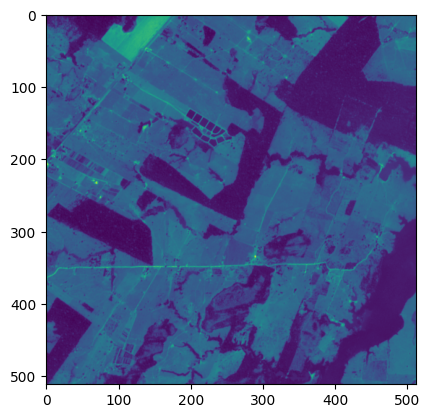

In [ ]:
# Show example train image
plt.imshow((np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir2,training_images_list2[20])))[0,:,:]))

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].astype('float32')
  training_images2[i] = training_images2[i].T

for i in range(len(training_masks2)):
  training_masks2[i] = training_masks2[i].reshape(1,512,512,1)
  training_masks2[i] = training_masks2[i].T

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].astype('float32')
  validation_images2[i] = validation_images2[i].T

for i in range(len(validation_masks2)):
  validation_masks2[i] = validation_masks2[i].reshape(1,512,512,1)
  validation_masks2[i] = validation_masks2[i].T

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].astype('float32')
  test_images2[i] = test_images2[i].T

for i in range(len(test_masks2)):
  test_masks2[i] = test_masks2[i].reshape(1,512,512,1)
  test_masks2[i] = test_masks2[i].T

for i in range(len(training_images2)):
  training_images2[i] = training_images2[i].reshape(-1,512,512,4)

for i in range(len(validation_images2)):
  validation_images2[i] = validation_images2[i].reshape(-1,512,512,4)

for i in range(len(test_images2)):
  test_images2[i] = test_images2[i].reshape(-1,512,512,4)

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_amazon = tf.data.Dataset.from_tensor_slices((training_images2[0:250], training_masks2[0:250]))
validation_df_4band_amazon = tf.data.Dataset.from_tensor_slices((validation_images2, validation_masks2))

## 4-band Atlantic Forest dataset

In [ ]:
download = True # True if files don't already exist in same directory
base_dir3 = r"./ATLANTIC FOREST/"

In [ ]:
# Download data (Atlantic Forest)
if download:
    url = 'https://zenodo.org/record/4498086/files/ATLANTIC%20FOREST.rar?download=1'
    r = requests.get(url, allow_redirects=True)
    open('data3.rar', 'wb').write(r.content)

    if sys.platform != 'darwin':
        pyunpack.Archive('data3.rar').extractall('')

    else:
        with RarFile('data3.rar') as rf:
            rf.extractall()


In [ ]:
# Ingest images and normalise

## Training images
training_images_list3 = os.listdir(r"{}Training/image/".format(base_dir3))[0:250]
training_masks_list3 = []
training_images3 = []
for n in training_images_list3:
  training_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Training/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  training_images3.append(a)

## Training masks
training_masks3 = []
for n in training_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Training/label/{}".format(base_dir3,n))))
  training_masks3.append(a)

## Test images
test_images_list3 = os.listdir(r"{}Test/image/".format(base_dir3))
test_masks_list3 = []
test_images3 = []
for n in test_images_list3:
  test_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Test/image/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  test_images3.append(a)

## Test masks
test_masks3 = []
for n in test_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Test/mask/{}".format(base_dir3,n))))
  test_masks3.append(a)

## Validation images
validation_images_list3 = os.listdir(r"{}Validation/images/".format(base_dir3))
validation_masks_list3 = []
validation_images3 = []
for n in validation_images_list3:
  validation_masks_list3.append(n)
  a = (np.array(rxr.open_rasterio(r"{}Validation/images/{}".format(base_dir3,n))))
  a = (a-np.min(a)) / (np.max(a)-np.min(a))
  validation_images3.append(a)

## Validation masks
validation_masks3 = []
for n in validation_masks_list3:
  a = (np.array(rxr.open_rasterio(r"{}Validation/masks/{}".format(base_dir3,n))))
  validation_masks3.append(a)

In [ ]:
# Pre-process data, reshaping and transposing
for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].astype('float32')
  training_images3[i] = training_images3[i].T

for i in range(len(training_masks3)):
  training_masks3[i] = training_masks3[i].reshape(1,512,512,1)
  training_masks3[i] = training_masks3[i].T

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].astype('float32')
  validation_images3[i] = validation_images3[i].T

for i in range(len(validation_masks3)):
  validation_masks3[i] = validation_masks3[i].reshape(1,512,512,1)
  validation_masks3[i] = validation_masks3[i].T

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].astype('float32')
  test_images3[i] = test_images3[i].T

for i in range(len(test_masks3)):
  test_masks3[i] = test_masks3[i].reshape(1,512,512,1)
  test_masks3[i] = test_masks3[i].T


for i in range(len(training_images3)):
  training_images3[i] = training_images3[i].reshape(-1,512,512,4)

for i in range(len(validation_images3)):
  validation_images3[i] = validation_images3[i].reshape(-1,512,512,4)

for i in range(len(test_images3)):
  test_images3[i] = test_images3[i].reshape(-1,512,512,4)

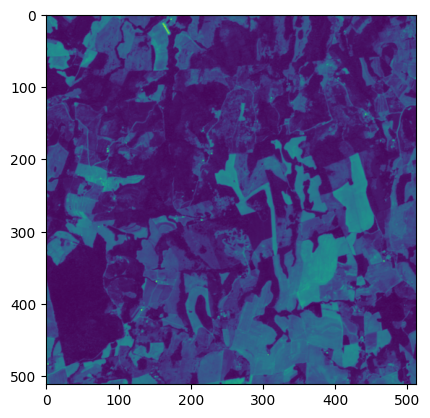

In [ ]:
# Plot example training image first band
plt.imshow(training_images3[0].reshape(512,512,4)[:,:,0])

In [ ]:
# Create TensorFlow datasets for training and validation sets
train_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((training_images3[0:250], training_masks3[0:250]))
validation_df_4band_atlantic = tf.data.Dataset.from_tensor_slices((validation_images3, validation_masks3))

# Models

## U-Net

In [ ]:
'''
  Convolutional block with set parameters and activation layer after
'''

def convBlock(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
  else:
    #conv = ZeroPadding2D((1,1))(input)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)

  conv = Activation(act)(conv)
  return conv

'''
  U-Net model
'''

def UNet(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size)

    ## Contraction phase
    conv1 = convBlock(inputs, 64, 3)
    conv1 = convBlock(conv1, 64, 3)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = convBlock(pool1, 128, 3)
    conv2 = convBlock(conv2, 128, 3)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    #drop2 = Dropout(drop_rate)(pool2)

    conv3 = convBlock(pool2, 256, 3)
    conv3 = convBlock(conv3, 256, 3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)
    #drop3 = Dropout(drop_rate)(pool3)

    conv4 = convBlock(pool3, 512, 3)
    conv4 = convBlock(conv4, 512, 3)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)
    #drop4 = Dropout(drop_rate)(pool4)

    conv5 = convBlock(pool4, 1024, 3)
    conv5 = convBlock(conv5, 1024, 3)

    ## Expansion phase
    up6 = (Conv2DTranspose(512, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = concatenate([conv4,up6])
    conv6 = convBlock(merge6, 512, 3)
    conv6 = convBlock(conv6, 512, 3)
    #conv6 = Dropout(drop_rate)(conv6)

    up7 = (Conv2DTranspose(256, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = concatenate([conv3,up7])
    conv7 = convBlock(merge7, 256, 3)
    conv7 = convBlock(conv7, 256, 3)
    #conv7 = Dropout(drop_rate)(conv7)

    up8 = (Conv2DTranspose(128, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv7))
    merge8 = concatenate([conv2,up8])
    conv8 = convBlock(merge8, 128, 3)
    conv8 = convBlock(conv8, 128, 3)
    #conv8 = Dropout(drop_rate)(conv8)

    up9 = (Conv2DTranspose(64, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv8))
    merge9 = concatenate([conv1,up9])
    conv9 = convBlock(merge9, 64, 3)
    conv9 = convBlock(conv9, 64, 3)

    # Output layer
    conv10 = convBlock(conv9, 1, 1, act='sigmoid')

    model = Model(inputs, conv10)

    model.compile(optimizer = Adam(learning_rate = lr), loss = 'binary_crossentropy', metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNet().summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (1, 512, 512, 64) │      1,792 │ input_layer[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (1, 512, 512, 64) │          0 │ conv2d[0][0]      │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (1, 512, 512, 64) │     36,928 │ activation[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (1, 512, 512, 64) │          0 │ conv2d_1[0][0]    │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (1, 256, 256, 64) │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (1, 256, 256,     │     73,856 │ max_pooling2d[0]… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (1, 256, 256,     │          0 │ conv2d_2[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (1, 256, 256,     │    147,584 │ activation_2[0][… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (1, 256, 256,     │          0 │ conv2d_3[0][0]    │
│ (Activation)        │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (1, 128, 128,     │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (1, 128, 128,     │    295,168 │ max_pooling2d_1[… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_4        │ (1, 128, 128,     │          0 │ conv2d_4[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (1, 128, 128,     │    590,080 │ activation_4[0][… │
│                     │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_5        │ (1, 128, 128,     │          0 │ conv2d_5[0][0]    │
│ (Activation)        │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (1, 64, 64, 256)  │          0 │ activation_5[0][… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (1, 64, 64, 512)  │  1,180,160 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_6        │ (1, 64, 64, 512)  │          0 │ conv2d_6[0][0]  

 Total params: 31,031,745 (118.38 MB)

 Trainable params: 31,031,745 (118.38 MB)

 Non-trainable params: 0 (0.00 B)

## Attention U-Net

In [ ]:
'''
  Convolutional block with two conv layers and two activation layers
'''

def convBlock2(input, filters, kernel, kernel_init='he_normal', act='relu', transpose=False):
  if transpose == False:
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2D(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)
  else:
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(input)
    conv = Activation(act)(conv)
    conv = Conv2DTranspose(filters, kernel, padding = 'same', kernel_initializer = kernel_init)(conv)
    conv = Activation(act)(conv)

  return conv

'''
  Attention block/mechanism
'''
def attention_block(x, gating, inter_shape, drop_rate=0.25):

    # Find shape of inputs
    shape_x = K.int_shape(x)
    shape_g = K.int_shape(gating)

    ## Process x vector and gating signal
    # x vector input and processing
    theta_x = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(x)
    theta_x = MaxPooling2D((2,2))(theta_x)
    shape_theta_x = K.int_shape(theta_x)

    # gating signal ""
    phi_g = Conv2D(inter_shape, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(gating)
    shape_phi_g = K.int_shape(phi_g)

    # Add components
    concat_xg = add([phi_g, theta_x])
    act_xg = Activation('relu')(concat_xg)

    # Apply convolution
    psi = Conv2D(1, kernel_size = 1, strides = 1, padding='same', kernel_initializer='he_normal', activation=None)(act_xg)

    # Apply sigmoid activation
    sigmoid_xg = Activation('sigmoid')(psi)
    shape_sigmoid = K.int_shape(sigmoid_xg)

    # UpSample and resample to correct size
    upsample_psi = UpSampling2D(
        interpolation='bilinear',
        size=(shape_x[1] // shape_sigmoid[1], shape_x[2] // shape_sigmoid[2])
    )(sigmoid_xg)

    # No tf.broadcast_to – Keras will broadcast automatically in multiply()
    y = multiply([upsample_psi, x])


    return y


'''
  Attention U-Net model
'''

def UNetAM(trained_weights = None, input_size = (512,512,3), drop_rate = 0.25, lr=0.0001, filter_base=16):

    ## Can add pretrained weights by specifying 'trained_weights'

    # Input layer
    inputs = Input(input_size, batch_size=1)

    ## Contraction phase
    conv = convBlock2(inputs, filter_base, 3)
    #conv0 = Dropout(drop_rate)(conv0)

    conv0 = MaxPooling2D(pool_size=(2, 2))(conv)
    conv0 = convBlock2(conv0, 2 * filter_base, 3)

    pool0 = MaxPooling2D(pool_size=(2, 2))(conv0)
    conv1 = convBlock2(pool0, 4 * filter_base, 3)
    #conv1 = Dropout(drop_rate)(conv1)

    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)
    conv2 = convBlock2(pool1, 8 * filter_base, 3)
    #conv2 = Dropout(drop_rate)(conv2)

    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)
    conv3 = convBlock2(pool2, 16 * filter_base, 3)
    #conv3 = Dropout(drop_rate)(conv3)

    ## Expansion phase
    up4 = (Conv2DTranspose(8 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv3))
    merge4 = attention_block(conv2, conv3, 8 * filter_base, drop_rate) # Attention gate
    conv4 = concatenate([up4, merge4])
    conv4 = convBlock2(conv4, 8 * filter_base, 3)

    up5 = (Conv2DTranspose(4 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv4))
    merge5 = attention_block(conv1, conv4, 4 * filter_base, drop_rate) # Attention gate
    conv5 = concatenate([up5, merge5])
    conv5 = convBlock2(conv5, 4 * filter_base, 3)

    up6 = (Conv2DTranspose(2 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv5))
    merge6 = attention_block(conv0, conv5, 2 * filter_base, drop_rate) # Attention gate
    conv6 = concatenate([up6, merge6])
    conv6 = convBlock2(conv6, 2 * filter_base, 3)

    up7 = (Conv2DTranspose(1 * filter_base, kernel_size=2, strides=2, kernel_initializer='he_normal')(conv6))
    merge7 = attention_block(conv, conv6, 1 * filter_base, drop_rate) # Attention gate
    conv7 = concatenate([up7, merge7])
    conv7 = concatenate([up7, conv])
    conv7 = convBlock2(conv7, 1 * filter_base, 3)

    ## Output layer
    out = convBlock(conv7, 1, 1, act='sigmoid')

    model = Model(inputs, out)

    model.compile(optimizer = Adam(learning_rate = lr), loss = binary_crossentropy, metrics = ['accuracy', 'mse'])

    if trained_weights != None:
    	model.load_weights(trained_weights)

    return model

In [ ]:
# Print model layers and number of parameters
UNetAM().summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (1, 512, 512, 3)  │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_19 (Conv2D)  │ (1, 512, 512, 16) │        448 │ input_layer_1[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_19       │ (1, 512, 512, 16) │          0 │ conv2d_19[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_20 (Conv2D)  │ (1, 512, 512, 16) │      2,320 │ activation_19[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_20       │ (1, 512, 512, 16) │          0 │ conv2d_20[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_4     │ (1, 256, 256, 16) │          0 │ activation_20[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_21 (Conv2D)  │ (1, 256, 256, 32) │      4,640 │ max_pooling2d_4[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_21       │ (1, 256, 256, 32) │          0 │ conv2d_21[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_22 (Conv2D)  │ (1, 256, 256, 32) │      9,248 │ activation_21[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_22       │ (1, 256, 256, 32) │          0 │ conv2d_22[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_5     │ (1, 128, 128, 32) │          0 │ activation_22[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_23 (Conv2D)  │ (1, 128, 128, 64) │     18,496 │ max_pooling2d_5[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_23       │ (1, 128, 128, 64) │          0 │ conv2d_23[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_24 (Conv2D)  │ (1, 128, 128, 64) │     36,928 │ activation_23[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_24       │ (1, 128, 128, 64) │          0 │ conv2d_24[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_6     │ (1, 64, 64, 64)   │          0 │ activation_24[0]… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_25 (Conv2D)  │ (1, 64, 64, 128)  │     73,856 │ max_pooling2d_6[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_25       │ (1, 64, 64, 128)  │          0 │ conv2d_25[0][0]   │
│ (Activation)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_26 (Conv2D)  │ (1, 64, 64, 128)  │    147,584 │ activation_25[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 2,006,292 (7.65 MB)

 Trainable params: 2,006,292 (7.65 MB)

 Non-trainable params: 0 (0.00 B)

# Train on RGB feature data

## U-Net

In [ ]:
# Train U-Net with generator
model_unet = UNet(input_size=(512,512,3), lr=0.0001)
save_model = ModelCheckpoint('unet-3d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)

model_unet.fit(train, steps_per_epoch=100, epochs=30, validation_data = validation_df, callbacks=[save_model])

Epoch 1/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.6529 - loss: 0.5289 - mse: 0.1807
Epoch 1: val_accuracy improved from -inf to 0.91889, saving model to unet-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 38s 158ms/step - accuracy: 0.6544 - loss: 0.5273 - mse: 0.1801 - val_accuracy: 0.9189 - val_loss: 0.2238 - val_mse: 0.0638
Epoch 2/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 102ms/step - accuracy: 0.9249 - loss: 0.2087 - mse: 0.0585
Epoch 2: val_accuracy did not improve from 0.91889
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 108ms/step - accuracy: 0.9249 - loss: 0.2086 - mse: 0.0584 - val_accuracy: 0.9156 - val_loss: 0.2216 - val_mse: 0.0638
Epoch 3/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9161 - loss: 0.2211 - mse: 0.0637
Epoch 3: val_accuracy did not improve from 0.91889
100/100 ━━━━━━━━━━━━━━━━━━━━ 11s 105ms/step - accuracy: 0.9162 - loss: 0.2211 - mse: 0.0636 - val_accuracy: 0.8817 - val_loss: 0.2886 - val_mse: 0.0884
Epoch 4/30
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

In [ ]:
# Save model training history
np.save('unet-3d-history.npy',model_unet.history.history)

In [ ]:
# Copy models to drive
!cp unet-3d.keras drive/MyDrive/Diss/
!cp unet-3d-history.npy drive/MyDrive/Diss/

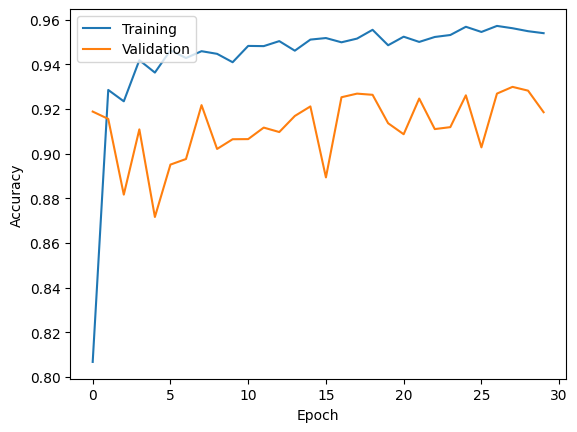

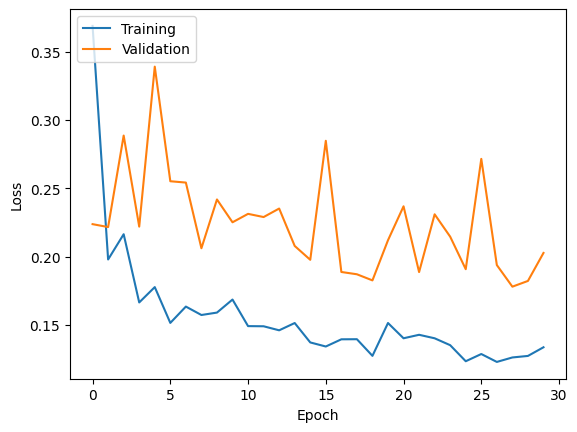

In [ ]:
# Plot accuracy and loss

## Accuracy
plt.plot(model_unet.history.history['accuracy'])
plt.plot(model_unet.history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(model_unet.history.history['loss'])
plt.plot(model_unet.history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

## Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet = UNetAM(lr=0.0005, filter_base=16)
save_model_am = ModelCheckpoint('unet-attention-3d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
train = trainGenerator(1, t_images, t_masks, data_gen_args, save_to_dir=None)
model_attention_unet.fit(train, steps_per_epoch=100, epochs=50, validation_data = validation_df, callbacks=[save_model_am])

Epoch 1/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.5882 - loss: 0.5995 - mse: 0.2093
Epoch 1: val_accuracy improved from -inf to 0.89505, saving model to unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 30s 113ms/step - accuracy: 0.5897 - loss: 0.5982 - mse: 0.2088 - val_accuracy: 0.8951 - val_loss: 0.2559 - val_mse: 0.0771
Epoch 2/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.9153 - loss: 0.2315 - mse: 0.0650
Epoch 2: val_accuracy improved from 0.89505 to 0.89543, saving model to unet-attention-3d.keras
100/100 ━━━━━━━━━━━━━━━━━━━━ 8s 80ms/step - accuracy: 0.9154 - loss: 0.2314 - mse: 0.0650 - val_accuracy: 0.8954 - val_loss: 0.2769 - val_mse: 0.0814
Epoch 3/50
100/100 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step - accuracy: 0.9017 - loss: 0.2622 - mse: 0.0776
Epoch 3: val_accuracy did not improve from 0.89543
100/100 ━━━━━━━━━━━━━━━━━━━━ 7s 75ms/step - accuracy: 0.9018 - loss: 0.2621 - mse: 0.0775 - val_accuracy: 0.8774 - val_loss: 0.2830 - val_mse: 0.0874
Epoch

In [ ]:
# Save model history
np.save('unet-attention-3d-history.npy',model_attention_unet.history.history)

In [ ]:
# Copy models to drive

!mkdir -p /content/drive/MyDrive/Diss

!cp unet-attention-3d.keras /content/drive/MyDrive/Diss/
!cp unet-attention-3d-history.npy /content/drive/MyDrive/Diss/


# Train on 4-band data

## Train on 4-band Amazon data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band = UNet(input_size=(512,512,4))
save_model_4band = ModelCheckpoint('unet-4d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band.fit(train_df_4band_amazon, epochs = 20, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7633 - loss: 0.4556 - mse: 0.1517
Epoch 1: val_accuracy improved from -inf to 0.90093, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 41s 121ms/step - accuracy: 0.7637 - loss: 0.4551 - mse: 0.1515 - val_accuracy: 0.9009 - val_loss: 0.2557 - val_mse: 0.0752
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.9143 - loss: 0.2230 - mse: 0.0651
Epoch 2: val_accuracy improved from 0.90093 to 0.92378, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 118ms/step - accuracy: 0.9144 - loss: 0.2229 - mse: 0.0651 - val_accuracy: 0.9238 - val_loss: 0.2021 - val_mse: 0.0581
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.9292 - loss: 0.1814 - mse: 0.0529
Epoch 3: val_accuracy improved from 0.92378 to 0.93807, saving model to unet-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.9293 - loss: 0.1813 - mse: 0.0529 - val_accuracy: 0.9381 - val_loss: 0.1642 -

In [ ]:
# Save model history
np.save('unet-4d-history.npy',model_unet_4band.history.history)

In [ ]:
# Copy models to drive
!cp unet-4d.keras drive/MyDrive/Diss/
!cp unet-4d-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train U-Net with generator
model_attention_unet_4band = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention = ModelCheckpoint('unet-attention-4d.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band.fit(train_df_4band_amazon, epochs = 60, validation_data = validation_df_4band_amazon, callbacks=[save_model_4band_attention])

Epoch 1/60
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.7074 - loss: 0.5757 - mse: 0.1838
Epoch 1: val_accuracy improved from -inf to 0.88858, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 21s 28ms/step - accuracy: 0.7088 - loss: 0.5738 - mse: 0.1831 - val_accuracy: 0.8886 - val_loss: 0.2715 - val_mse: 0.0823
Epoch 2/60
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9013 - loss: 0.2447 - mse: 0.0731
Epoch 2: val_accuracy improved from 0.88858 to 0.90028, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9014 - loss: 0.2445 - mse: 0.0730 - val_accuracy: 0.9003 - val_loss: 0.2458 - val_mse: 0.0739
Epoch 3/60
248/250 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step - accuracy: 0.9147 - loss: 0.2118 - mse: 0.0629
Epoch 3: val_accuracy improved from 0.90028 to 0.91312, saving model to unet-attention-4d.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 20ms/step - accuracy: 0.9148 - loss: 0.2117 - mse: 0.0629 - val_accuracy: 0.913

In [ ]:
# Save model history
np.save('unet-attention-4d-history.npy',model_attention_unet_4band.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-4d.keras drive/MyDrive/Diss/
!cp unet-attention-4d-history.npy drive/MyDrive/Diss/

## Train on 4-band Atlantic data

### U-Net

In [ ]:
# Train U-Net with generator
model_unet_4band_atlantic = UNet(input_size=(512, 512, 4), lr=0.0001)
save_model_4band_atlantic = ModelCheckpoint('unet-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 20, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_atlantic])

Epoch 1/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.7387 - loss: 0.5032 - mse: 0.1709
Epoch 1: val_accuracy improved from -inf to 0.84422, saving model to unet-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 40s 121ms/step - accuracy: 0.7390 - loss: 0.5029 - mse: 0.1708 - val_accuracy: 0.8442 - val_loss: 0.3742 - val_mse: 0.1192
Epoch 2/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step - accuracy: 0.8447 - loss: 0.3571 - mse: 0.1179
Epoch 2: val_accuracy improved from 0.84422 to 0.86334, saving model to unet-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 116ms/step - accuracy: 0.8447 - loss: 0.3570 - mse: 0.1179 - val_accuracy: 0.8633 - val_loss: 0.3280 - val_mse: 0.1038
Epoch 3/20
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.8537 - loss: 0.3330 - mse: 0.1090
Epoch 3: val_accuracy improved from 0.86334 to 0.88133, saving model to unet-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 29s 117ms/step - accuracy: 0.8537 - loss: 0.3330 - mse: 0.1090 - val_accuracy: 

In [ ]:
# Save model history
np.save('unet-4d-atlantic-history.npy',model_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-4d-atlantic.keras drive/MyDrive/Diss/
!cp unet-4d-atlantic-history.npy drive/MyDrive/Diss/

### Attention U-Net

In [ ]:
# Train Attention U-Net with generator
model_attention_unet_4band_atlantic = UNetAM(input_size=(512,512,4), filter_base=16, lr=0.0005)
save_model_4band_attention_atlantic = ModelCheckpoint('unet-attention-4d-atlantic.keras', monitor='val_accuracy',verbose=1, save_best_only=True)
model_attention_unet_4band_atlantic.fit(train_df_4band_atlantic, epochs = 60, validation_data = validation_df_4band_atlantic, callbacks=[save_model_4band_attention_atlantic])

Epoch 1/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.7356 - loss: 0.5174 - mse: 0.1757
Epoch 1: val_accuracy improved from -inf to 0.85255, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 22s 29ms/step - accuracy: 0.7359 - loss: 0.5171 - mse: 0.1755 - val_accuracy: 0.8526 - val_loss: 0.3632 - val_mse: 0.1151
Epoch 2/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8493 - loss: 0.3390 - mse: 0.1105
Epoch 2: val_accuracy improved from 0.85255 to 0.87548, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8493 - loss: 0.3390 - mse: 0.1105 - val_accuracy: 0.8755 - val_loss: 0.3150 - val_mse: 0.1000
Epoch 3/60
250/250 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.8591 - loss: 0.3038 - mse: 0.0982
Epoch 3: val_accuracy improved from 0.87548 to 0.88867, saving model to unet-attention-4d-atlantic.keras
250/250 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.8591 - loss: 0.3038 - mse: 0

In [ ]:
# Save model history
np.save('unet-attention-4d-atlantic-history.npy',model_attention_unet_4band_atlantic.history.history)

In [ ]:
# Copy models to drive
!cp unet-attention-4d-atlantic.keras drive/MyDrive/Diss/
!cp unet-attention-4d-atlantic-history.npy drive/MyDrive/Diss/

# Import Models and Compute Metrics

## RGB

In [ ]:
# Load 3-dim models and history stats
attention_unet = load_model('unet-attention-3d.keras')
unet = load_model('unet-3d.keras')

unet_history = np.load('unet-3d-history.npy', allow_pickle='TRUE').item()
attention_unet_history = np.load('unet-attention-3d-history.npy', allow_pickle='TRUE').item()

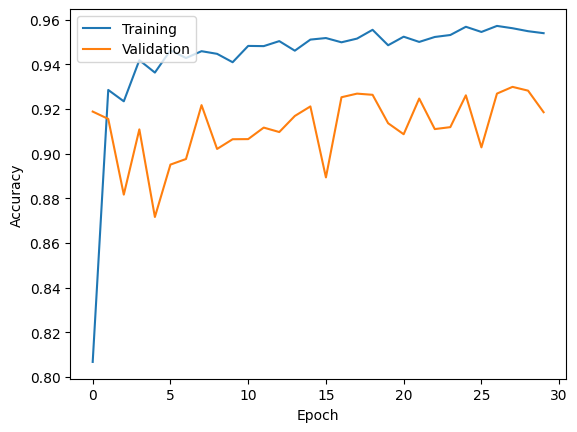

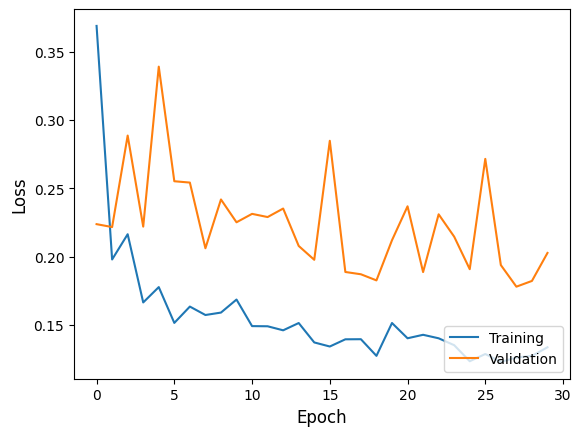

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_history['accuracy'])
plt.plot(unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_history['loss'])
plt.plot(unet_history['val_loss'])
plt.ylabel('Loss', size=12)
plt.xlabel('Epoch', size=12)
plt.legend(['Training', 'Validation'], loc='lower right')

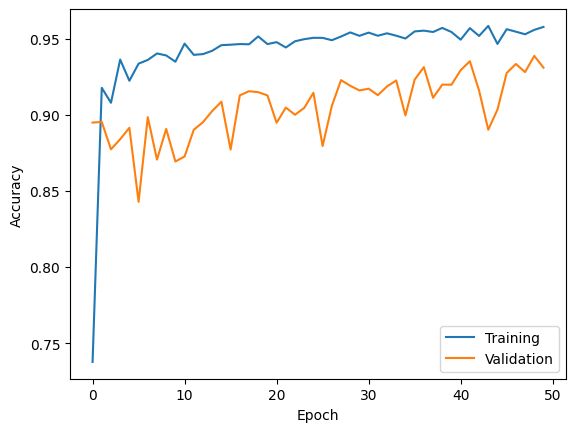

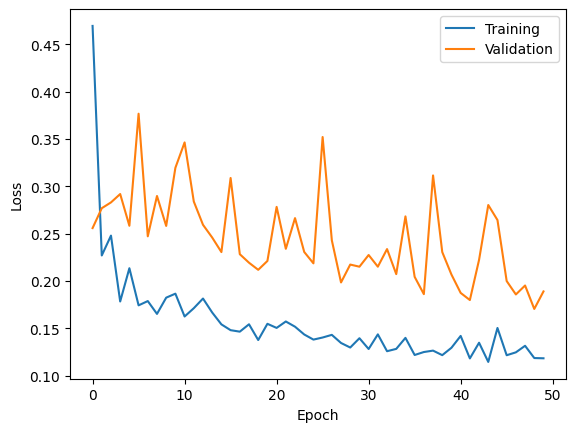

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_history['accuracy'])
plt.plot(attention_unet_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show()

## Loss
plt.plot(attention_unet_history['loss'])
plt.plot(attention_unet_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

In [ ]:
# Scores of each model
unet_score = (score_eval(unet, validation_images, validation_masks))
am_unet_score = (score_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━

In [ ]:
# Precision and recall of each model
unet_precision = (precision_eval(unet, validation_images, validation_masks))
am_unet_precision = (precision_eval(attention_unet, validation_images, validation_masks))

unet_recall = (recall_eval(unet, validation_images, validation_masks))
am_unet_recall = (recall_eval(attention_unet, validation_images, validation_masks))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━

In [ ]:
# F1-scores of each model
unet_f1_score = (f1_score_eval_basic(unet_precision, unet_recall))
am_unet_f1_score = (f1_score_eval_basic(am_unet_precision, am_unet_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_score), np.std(unet_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_score), np.std(am_unet_score))

U-Net accuracy:  0.9299657821655274 0.0671644092068904
Attention U-Net accuracy:  0.9388935089111328 0.05765712786357882


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_precision), np.std(unet_precision))
print('Attention U-Net precision: ', np.mean(am_unet_precision), np.std(am_unet_precision))

U-Net precision:  0.9471445575206104 0.04290839872501013
Attention U-Net precision:  0.951125253197279 0.03808695921593543


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_recall), np.std(unet_recall))
print('Attention U-Net recall: ', np.mean(am_unet_recall), np.std(am_unet_recall))

U-Net recall:  0.9299657821655274 0.0671644092068904
Attention U-Net recall:  0.9388935089111328 0.05765712786357882


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_f1_score))

U-Net F1-score:  0.9384765622310225
Attention U-Net F1-score:  0.9449698006089529


## 4-band

### Amazon Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d = load_model('unet-attention-4d.keras')
unet_4d = load_model('unet-4d.keras')

unet_4d_history = np.load('unet-4d-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_history = np.load('unet-attention-4d-history.npy', allow_pickle='TRUE').item()

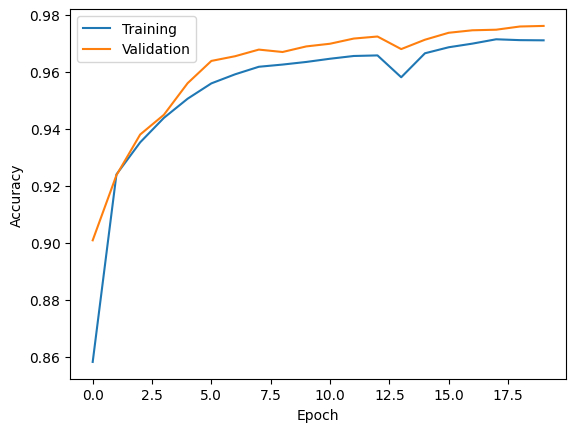

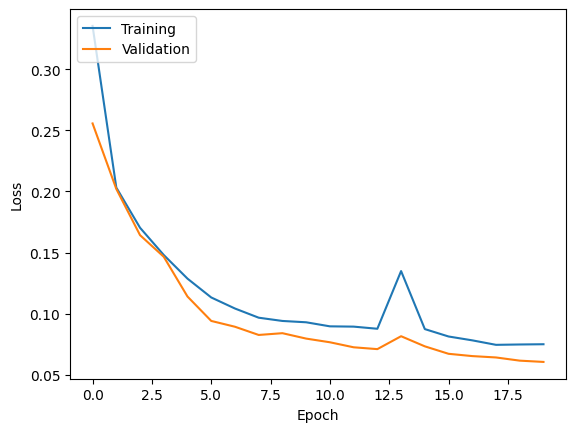

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_history['accuracy'])
plt.plot(unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_history['loss'])
plt.plot(unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

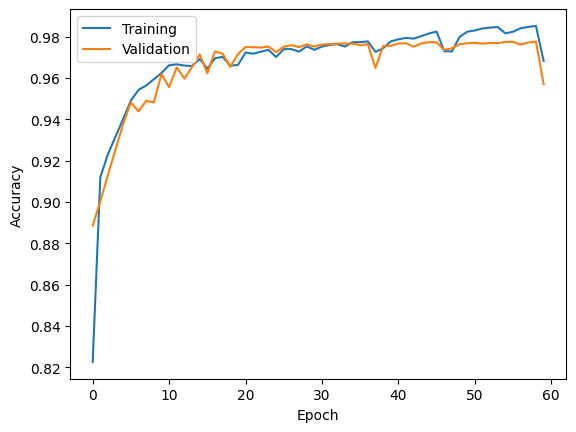

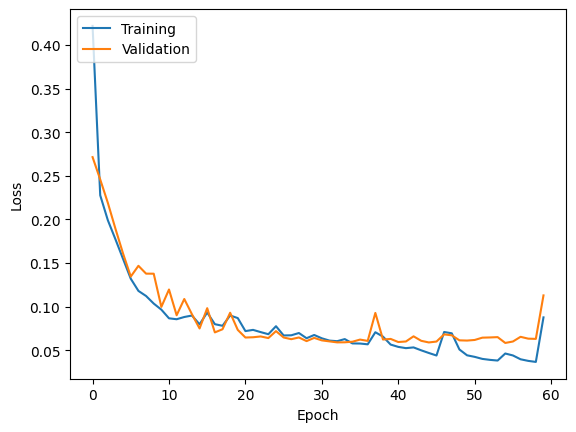

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_history['accuracy'])
plt.plot(attention_unet_4d_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_history['loss'])
plt.plot(attention_unet_4d_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_score = (score_eval2(unet_4d, validation_images2, validation_masks2))
am_unet_4d_score = (score_eval2(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Precision and recall of each model
unet_4d_precision = (precision_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_precision = (precision_eval(attention_unet_4d, validation_images2, validation_masks2))

unet_4d_recall = (recall_eval(unet_4d, validation_images2, validation_masks2))
am_unet_4d_recall = (recall_eval(attention_unet_4d, validation_images2, validation_masks2))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━

In [ ]:
# F1-scores of each model
unet_4d_f1_score = (f1_score_eval_basic(unet_4d_precision, unet_4d_recall))
am_unet_4d_f1_score = (f1_score_eval_basic(am_unet_4d_precision, am_unet_4d_recall))

In [ ]:
# Print score eval results for each model
print('U-Net accuracy: ', np.mean(unet_4d_score), np.std(unet_4d_score))
print('Attention U-Net accuracy: ', np.mean(am_unet_4d_score), np.std(am_unet_4d_score))

U-Net accuracy:  0.9762039947509765 0.022226038984484983
Attention U-Net accuracy:  0.9775673294067383 0.021537959307830153


In [ ]:
# Print precision eval results for each model
print('U-Net precision: ', np.mean(unet_4d_precision), np.std(unet_4d_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision), np.std(am_unet_4d_precision))

U-Net precision:  0.9778660278667162 0.018990572772509883
Attention U-Net precision:  0.9791074180777573 0.01876693098946135


In [ ]:
# Print recall eval results for each model
print('U-Net recall: ', np.mean(unet_4d_recall), np.std(unet_4d_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall), np.std(am_unet_4d_recall))

U-Net recall:  0.9762039947509765 0.022226038984484983
Attention U-Net recall:  0.9775673294067383 0.021537959307830153


In [ ]:
# Print f1-score eval results for each model
print('U-Net F1-score: ', np.mean(unet_4d_f1_score))
print('Attention U-Net F1-score: ', np.mean(am_unet_4d_f1_score))

U-Net F1-score:  0.9770343044881986
Attention U-Net F1-score:  0.9783367676442957


### Amazon on unseen Atlantic data

In [ ]:
# Score
unet_amazon_on_atlantic_score = score_eval2(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)
am_unet_amazon_on_atlantic_score = score_eval2(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3)

# Precision
unet_amazon_on_atlantic_precision = (precision_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_precision = (precision_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# Recall
unet_amazon_on_atlantic_recall = (recall_eval(unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))
am_unet_amazon_on_atlantic_recall = (recall_eval(attention_unet_4d, validation_images3+test_images3, validation_masks3+test_masks3))

# F1-scores of each model
unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(unet_amazon_on_atlantic_precision, unet_amazon_on_atlantic_recall))
am_unet_amazon_on_atlantic_f1_score = (f1_score_eval_basic(am_unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_amazon_on_atlantic_score), np.std(unet_amazon_on_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_amazon_on_atlantic_score), np.std(am_unet_amazon_on_atlantic_score))

print('U-Net precision: ', np.mean(unet_amazon_on_atlantic_precision), np.std(unet_amazon_on_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_amazon_on_atlantic_precision), np.std(am_unet_amazon_on_atlantic_precision))

print('U-Net recall: ', np.mean(unet_amazon_on_atlantic_recall), np.std(unet_amazon_on_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_amazon_on_atlantic_recall), np.std(am_unet_amazon_on_atlantic_recall))

print('U-Net F1-score: ', unet_amazon_on_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_amazon_on_atlantic_f1_score)

U-Net score:  0.8542702992757162 0.12836392636430188
Attention U-Net score:  0.8591636975606283 0.12318329659878245
U-Net precision:  0.9182457209064412 0.037800420126349536
Attention U-Net precision:  0.9191973657882335 0.03905012219444417
U-Net recall:  0.8542702992757162 0.12836392636430188
Attention U-Net recall:  0.8591636975606283 0.12318329659878245
U-Net F1-score:  0.8851034776281201
Attention U-Net F1-score:  0.8881672275161417


### Atlantic Data

In [ ]:
# Load 4-dim models and history stats
attention_unet_4d_atlantic = load_model('unet-attention-4d-atlantic.keras')
unet_4d_atlantic = load_model('unet-4d-atlantic.keras')

unet_4d_atlantic_history = np.load('unet-4d-atlantic-history.npy', allow_pickle='TRUE').item()
attention_unet_4d_atlantic_history = np.load('unet-attention-4d-atlantic-history.npy', allow_pickle='TRUE').item()

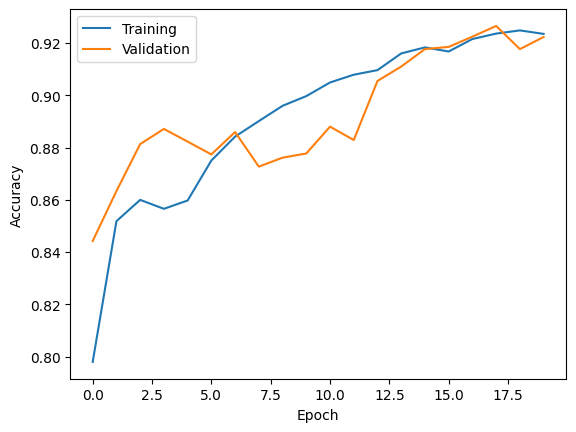

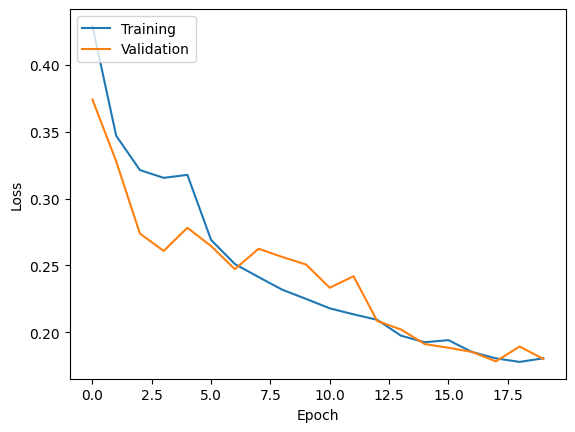

In [ ]:
# Plot accuracy and loss for U-Net

## Accuracy
plt.plot(unet_4d_atlantic_history['accuracy'])
plt.plot(unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(unet_4d_atlantic_history['loss'])
plt.plot(unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

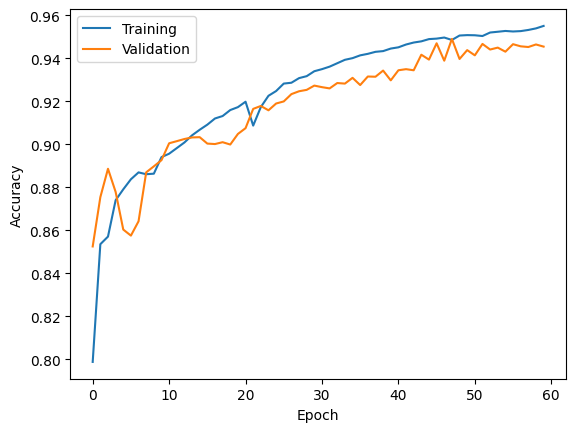

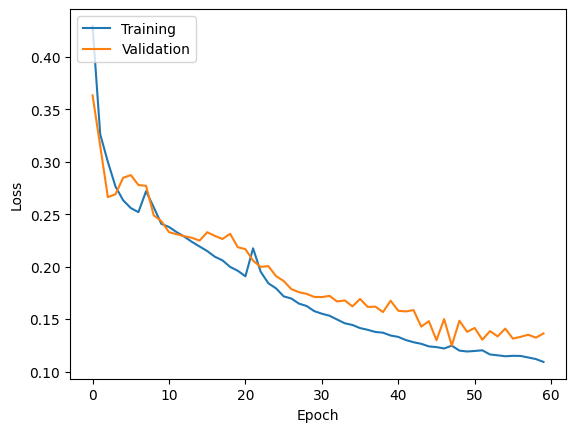

In [ ]:
# Plot accuracy and loss for Attention U-Net

## Accuracy
plt.plot(attention_unet_4d_atlantic_history['accuracy'])
plt.plot(attention_unet_4d_atlantic_history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')
plt.show()

## Loss
plt.plot(attention_unet_4d_atlantic_history['loss'])
plt.plot(attention_unet_4d_atlantic_history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper left')

In [ ]:
# Scores of each model
unet_4d_atlantic_score = (score_eval2(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_score = (score_eval2(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision = (precision_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_precision = (precision_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

unet_4d_atlantic_recall = (recall_eval(unet_4d_atlantic, validation_images3, validation_masks3))
am_unet_4d_atlantic_recall = (recall_eval(attention_unet_4d_atlantic, validation_images3, validation_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score = (f1_score_eval_basic(unet_4d_atlantic_precision, unet_4d_atlantic_recall))
am_unet_4d_atlantic_f1_score = (f1_score_eval_basic(am_unet_4d_atlantic_precision, am_unet_4d_atlantic_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_4d_atlantic_score), np.std(unet_4d_atlantic_score))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score), np.std(am_unet_4d_atlantic_score))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision), np.std(unet_4d_atlantic_precision))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision), np.std(am_unet_4d_atlantic_precision))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall), np.std(unet_4d_atlantic_recall))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall), np.std(am_unet_4d_atlantic_recall))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score)

U-Net score:  0.9265802383422852 0.04601503289151416
Attention U-Net score:  0.9490564346313477 0.03264119099391875
U-Net precision:  0.9345741712156027 0.03659888790046846
Attention U-Net precision:  0.9513473379388816 0.027138617988700715
U-Net recall:  0.9265802383422852 0.04601503289151416
Attention U-Net recall:  0.9490564346313477 0.03264119099391875
U-Net F1-score:  0.9305600372181938
Attention U-Net F1-score:  0.9502005054633018


### Atlantic on unseen Amazon data

In [ ]:
# Score
unet_atlantic_on_amazon_score = score_eval2(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)
am_unet_atlantic_on_amazon_score = score_eval2(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2)

# Precision
unet_atlantic_on_amazon_precision = (precision_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_precision = (precision_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# Recall
unet_atlantic_on_amazon_recall = (recall_eval(unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))
am_unet_atlantic_on_amazon_recall = (recall_eval(attention_unet_4d_atlantic, validation_images2+test_images2, validation_masks2+test_masks2))

# F1-scores of each model
unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(unet_atlantic_on_amazon_precision, unet_atlantic_on_amazon_recall))
am_unet_atlantic_on_amazon_f1_score = (f1_score_eval_basic(am_unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_recall))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics
print('U-Net score: ', np.mean(unet_atlantic_on_amazon_score), np.std(unet_atlantic_on_amazon_score))
print('Attention U-Net score: ', np.mean(am_unet_atlantic_on_amazon_score), np.std(am_unet_atlantic_on_amazon_score))

print('U-Net precision: ', np.mean(unet_atlantic_on_amazon_precision), np.std(unet_atlantic_on_amazon_precision))
print('Attention U-Net precision: ', np.mean(am_unet_atlantic_on_amazon_precision), np.std(am_unet_atlantic_on_amazon_precision))

print('U-Net recall: ', np.mean(unet_atlantic_on_amazon_recall), np.std(unet_atlantic_on_amazon_recall))
print('Attention U-Net recall: ', np.mean(am_unet_atlantic_on_amazon_recall), np.std(am_unet_atlantic_on_amazon_recall))

print('U-Net F1-score: ', unet_atlantic_on_amazon_f1_score)
print('Attention U-Net F1-score: ', am_unet_atlantic_on_amazon_f1_score)

U-Net score:  0.9039643287658692 0.07955963070699604
Attention U-Net score:  0.9178111394246419 0.0673050814029993
U-Net precision:  0.9322634735532153 0.04569025138179155
Attention U-Net precision:  0.9386418214001312 0.04468769783410032
U-Net recall:  0.9039643287658692 0.07955963070699604
Attention U-Net recall:  0.9178111394246419 0.0673050814029993
U-Net F1-score:  0.9178958340998115
Attention U-Net F1-score:  0.9281096131066372


### Amazon and Atlantic unseen test data

In [ ]:
# Amazon trained model on Amazon test data
# Scores of each model
unet_4d_score_test = (score_eval2(unet_4d, test_images2, test_masks2))
am_unet_4d_score_test = (score_eval2(attention_unet_4d, test_images2, test_masks2))

# Precision and recall of each model
unet_4d_precision_test = (precision_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_precision_test = (precision_eval(attention_unet_4d, test_images2, test_masks2))

unet_4d_recall_test = (recall_eval(unet_4d, test_images2, test_masks2))
am_unet_4d_recall_test = (recall_eval(attention_unet_4d, test_images2, test_masks2))

# F1-scores of each model
unet_4d_f1_score_test = (f1_score_eval_basic(unet_4d_precision_test, unet_4d_recall_test))
am_unet_4d_f1_score_test = (f1_score_eval_basic(am_unet_4d_precision_test, am_unet_4d_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step


/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step


In [ ]:
# Atlantic trained model on Atlantic test data
# Scores of each model
unet_4d_atlantic_score_test = (score_eval2(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_score_test = (score_eval2(attention_unet_4d_atlantic, test_images3, test_masks3))

# Precision and recall of each model
unet_4d_atlantic_precision_test = (precision_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_precision_test = (precision_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

unet_4d_atlantic_recall_test = (recall_eval(unet_4d_atlantic, test_images3, test_masks3))
am_unet_4d_atlantic_recall_test = (recall_eval(attention_unet_4d_atlantic, test_images3, test_masks3))

# F1-scores of each model
unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(unet_4d_atlantic_precision_test, unet_4d_atlantic_recall_test))
am_unet_4d_atlantic_f1_score_test = (f1_score_eval_basic(am_unet_4d_atlantic_precision_test, am_unet_4d_atlantic_recall_test))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━

In [ ]:
# Print metrics for Amazon on Amazon Test set
print('U-Net score: ', np.mean(unet_4d_score_test), np.std(unet_4d_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_score_test), np.std(am_unet_4d_score_test))

print('U-Net precision: ', np.mean(unet_4d_precision_test), np.std(unet_4d_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_precision_test), np.std(am_unet_4d_precision_test))

print('U-Net recall: ', np.mean(unet_4d_recall_test), np.std(unet_4d_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_recall_test), np.std(am_unet_4d_recall_test))

print('U-Net F1-score: ', unet_4d_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_f1_score_test)

U-Net score:  0.9746686935424804 0.017888159851569923
Attention U-Net score:  0.9759273529052734 0.018413787363643908
U-Net precision:  0.9756197217826987 0.016365296589614078
Attention U-Net precision:  0.9768423170641005 0.016816892883506376
U-Net recall:  0.9746686935424804 0.017888159851569923
Attention U-Net recall:  0.9759273529052734 0.018413787363643908
U-Net F1-score:  0.9751439757854203
Attention U-Net F1-score:  0.9763846206328807


In [ ]:
# Print metrics for Atlantic on Atlantic Test set
print('U-Net score: ', np.mean(unet_4d_atlantic_score_test), np.std(unet_4d_atlantic_score_test))
print('Attention U-Net score: ', np.mean(am_unet_4d_atlantic_score_test), np.std(am_unet_4d_atlantic_score_test))

print('U-Net precision: ', np.mean(unet_4d_atlantic_precision_test), np.std(unet_4d_atlantic_precision_test))
print('Attention U-Net precision: ', np.mean(am_unet_4d_atlantic_precision_test), np.std(am_unet_4d_atlantic_precision_test))

print('U-Net recall: ', np.mean(unet_4d_atlantic_recall_test), np.std(unet_4d_atlantic_recall_test))
print('Attention U-Net recall: ', np.mean(am_unet_4d_atlantic_recall_test), np.std(am_unet_4d_atlantic_recall_test))

print('U-Net F1-score: ', unet_4d_atlantic_f1_score_test)
print('Attention U-Net F1-score: ', am_unet_4d_atlantic_f1_score_test)

U-Net score:  0.9220149993896485 0.0680575914467643
Attention U-Net score:  0.945172119140625 0.05267888264042192
U-Net precision:  0.9357995106040077 0.03548028774394467
Attention U-Net precision:  0.9520780402983338 0.02750962780711448
U-Net recall:  0.9220149993896485 0.0680575914467643
Attention U-Net recall:  0.945172119140625 0.05267888264042192
U-Net F1-score:  0.9288561162129515
Attention U-Net F1-score:  0.9486125110693203


# Produce metric datasets for export

## RGB data

In [ ]:
scores_3d = [unet_score, am_unet_score]
precision_3d = [unet_precision, am_unet_precision]
recall_3d = [unet_recall, am_unet_recall]
f1_scores_3d = [unet_f1_score, am_unet_f1_score]

import pandas as pd
metrics_3d = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_3d],
              'precision': [np.mean(n) for n in precision_3d],
              'recall': [np.mean(n) for n in recall_3d],
              'f1_score': [np.mean(n) for n in f1_scores_3d],
              'accuracy_std': [np.std(n) for n in scores_3d],
              'precision_std': [np.std(n) for n in precision_3d],
              'recall_std': [np.std(n) for n in recall_3d]
              }
metrics_3d = pd.DataFrame(metrics_3d)
metrics_3d.to_csv('metrics_3d.csv')
metrics_3d.to_csv('/content/drive/MyDrive/Diss/metrics_3d.csv')

## 4-band Amazon data

In [ ]:
scores_4d = [unet_4d_score, am_unet_4d_score]
precision_4d = [unet_4d_precision, am_unet_4d_precision]
recall_4d = [unet_4d_recall, am_unet_4d_recall]
f1_scores_4d = [unet_4d_f1_score, am_unet_4d_f1_score]

metrics_4d = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d],
              'precision': [np.mean(n) for n in precision_4d],
              'recall': [np.mean(n) for n in recall_4d],
              'f1_score': [np.mean(n) for n in f1_scores_4d],
              'accuracy_std': [np.std(n) for n in scores_4d],
              'precision_std': [np.std(n) for n in precision_4d],
              'recall_std': [np.std(n) for n in recall_4d]
              }
metrics_4d = pd.DataFrame(metrics_4d)
metrics_4d.to_csv('metrics_4d_amazon.csv')
metrics_4d.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon.csv')

## 4-band Atlantic Forest data

In [ ]:
scores_4d_atl = [unet_4d_atlantic_score, am_unet_4d_atlantic_score]
precision_4d_atl = [unet_4d_atlantic_precision, am_unet_4d_atlantic_precision]
recall_4d_atl = [unet_4d_atlantic_recall, am_unet_4d_atlantic_recall]
f1_scores_4d_atl = [unet_4d_atlantic_f1_score, am_unet_4d_atlantic_f1_score]

metrics_4d_atl = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl],
              'precision': [np.mean(n) for n in precision_4d_atl],
              'recall': [np.mean(n) for n in recall_4d_atl],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl],
              'accuracy_std': [np.std(n) for n in scores_4d_atl],
              'precision_std': [np.std(n) for n in precision_4d_atl],
              'recall_std': [np.std(n) for n in recall_4d_atl]
              }
metrics_4d_atl = pd.DataFrame(metrics_4d_atl)
metrics_4d_atl.to_csv('metrics_4d_atlantic_forest.csv')
metrics_4d_atl.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_forest.csv')

## Test set data

In [ ]:
scores_4d_test = [unet_4d_score_test, am_unet_4d_score_test]
precision_4d_test = [unet_4d_precision_test, am_unet_4d_precision_test]
recall_4d_test = [unet_4d_recall_test, am_unet_4d_recall_test]
f1_scores_4d_test = [unet_4d_f1_score_test, am_unet_4d_f1_score_test]

metrics_4d_test = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_test],
              'precision': [np.mean(n) for n in precision_4d_test],
              'recall': [np.mean(n) for n in recall_4d_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_test],
              'accuracy_std': [np.std(n) for n in scores_4d_test],
              'precision_std': [np.std(n) for n in precision_4d_test],
              'recall_std': [np.std(n) for n in recall_4d_test]
              }
metrics_4d_test = pd.DataFrame(metrics_4d_test)
metrics_4d_test.to_csv('metrics_4d_amazon_test.csv')
metrics_4d_test.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon_test.csv')

In [ ]:
scores_4d_atl_test = [unet_4d_atlantic_score_test, am_unet_4d_atlantic_score_test]
precision_4d_atl_test = [unet_4d_atlantic_precision_test, am_unet_4d_atlantic_precision_test]
recall_4d_atl_test = [unet_4d_atlantic_recall_test, am_unet_4d_atlantic_recall_test]
f1_scores_4d_atl_test = [unet_4d_atlantic_f1_score_test, am_unet_4d_atlantic_f1_score_test]

metrics_4d_atl_test = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_4d_atl_test],
              'precision': [np.mean(n) for n in precision_4d_atl_test],
              'recall': [np.mean(n) for n in recall_4d_atl_test],
              'f1_score': [np.mean(n) for n in f1_scores_4d_atl_test],
              'accuracy_std': [np.std(n) for n in scores_4d_atl_test],
              'precision_std': [np.std(n) for n in precision_4d_atl_test],
              'recall_std': [np.std(n) for n in recall_4d_atl_test]
              }
metrics_4d_atl_test = pd.DataFrame(metrics_4d_atl_test)
metrics_4d_atl_test.to_csv('metrics_4d_atlantic_forest_test.csv')
metrics_4d_atl_test.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_forest_test.csv')

## Testing on opposite dataset (e.g. train on Amazon, test on Atlantic)

In [ ]:
scores_amazon_on_atlantic = [unet_amazon_on_atlantic_score, am_unet_amazon_on_atlantic_score]
precision_amazon_on_atlantic = [unet_amazon_on_atlantic_precision, am_unet_amazon_on_atlantic_precision]
recall_amazon_on_atlantic = [unet_amazon_on_atlantic_recall, am_unet_amazon_on_atlantic_recall]
f1_scores_amazon_on_atlantic = [unet_amazon_on_atlantic_f1_score, am_unet_amazon_on_atlantic_f1_score]

metrics_4d_amazon_on_atlantic = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_amazon_on_atlantic],
              'precision': [np.mean(n) for n in precision_amazon_on_atlantic],
              'recall': [np.mean(n) for n in recall_amazon_on_atlantic],
              'f1_score': [np.mean(n) for n in f1_scores_amazon_on_atlantic],
              'accuracy_std': [np.std(n) for n in scores_amazon_on_atlantic],
              'precision_std': [np.std(n) for n in precision_amazon_on_atlantic],
              'recall_std': [np.std(n) for n in recall_amazon_on_atlantic]
              }
metrics_4d_amazon_on_atlantic = pd.DataFrame(metrics_4d_amazon_on_atlantic)
metrics_4d_amazon_on_atlantic.to_csv('metrics_4d_amazon_on_atlantic.csv')
metrics_4d_amazon_on_atlantic.to_csv('/content/drive/MyDrive/Diss/metrics_4d_amazon_on_atlantic.csv')

In [ ]:
scores_atlantic_on_amazon = [unet_atlantic_on_amazon_score, am_unet_atlantic_on_amazon_score]
precision_atlantic_on_amazon = [unet_atlantic_on_amazon_precision, am_unet_atlantic_on_amazon_precision]
recall_atlantic_on_amazon = [unet_atlantic_on_amazon_recall, am_unet_atlantic_on_amazon_recall]
f1_scores_atlantic_on_amazon = [unet_atlantic_on_amazon_f1_score, am_unet_atlantic_on_amazon_f1_score]

metrics_4d_atlantic_on_amazon = {'classifier': ['U-Net', 'Attention U-Net'],
              'accuracy': [np.mean(n) for n in scores_atlantic_on_amazon],
              'precision': [np.mean(n) for n in precision_atlantic_on_amazon],
              'recall': [np.mean(n) for n in recall_atlantic_on_amazon],
              'f1_score': [np.mean(n) for n in f1_scores_atlantic_on_amazon],
              'accuracy_std': [np.std(n) for n in scores_atlantic_on_amazon],
              'precision_std': [np.std(n) for n in precision_atlantic_on_amazon],
              'recall_std': [np.std(n) for n in recall_atlantic_on_amazon]
              }
metrics_4d_atlantic_on_amazon = pd.DataFrame(metrics_4d_atlantic_on_amazon)
metrics_4d_atlantic_on_amazon.to_csv('metrics_4d_atlantic_on_amazon.csv')
# Save CSV directly to Google Drive
metrics_4d_atlantic_on_amazon.to_csv('/content/drive/MyDrive/Diss/metrics_4d_atlantic_on_amazon.csv', index=False)

In [ ]:
!ls -l /content


total 3464684
drwxr-xr-x 5 root root       4096 Feb  3  2021  AMAZON
drwxr-xr-x 5 root root       4096 May 27  2019 'Amazon Forest Dataset'
drwxr-xr-x 5 root root       4096 Feb  3  2021 'ATLANTIC FOREST'
-rw-r--r-- 1 root root 1173939349 Dec  7 10:42  data2.rar
-rw-r--r-- 1 root root 1161115721 Dec  7 10:48  data3.rar
-rw-r--r-- 1 root root   21783390 Dec  7 10:41  data.rar
drwx------ 5 root root       4096 Dec  7 10:41  drive
-rw-r--r-- 1 root root        380 Dec  7 12:05  metrics_3d.csv
-rw-r--r-- 1 root root        388 Dec  7 12:06  metrics_4d_amazon.csv
-rw-r--r-- 1 root root        384 Dec  7 12:08  metrics_4d_amazon_on_atlantic.csv
-rw-r--r-- 1 root root        389 Dec  7 12:07  metrics_4d_amazon_test.csv
-rw-r--r-- 1 root root        384 Dec  7 12:06  metrics_4d_atlantic_forest.csv
-rw-r--r-- 1 root root        379 Dec  7 12:08  metrics_4d_atlantic_forest_test.csv
-rw-r--r-- 1 root root        381 Dec  7 12:09  metrics_4d_atlantic_on_amazon.csv
drwxr-xr-x 1 root root       4096